In [29]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD
from time import time
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib, os, math

os.environ["CUDA_VISIBLE_DEVICES"]="0"

### 1.Prepare data

In [2]:
# import the npy dataset
# 2k 224 npy
X_train = np.load('/home/zxt/data/224/2k/X_train_224.npy')
X_validate = np.load('/home/zxt/data/224/2k/X_validate_224.npy')
X_test = np.load('/home/zxt/data/224/2k/X_test_224.npy')
Y_train = np.load('/home/zxt/data/224/2k/Y_train_224.npy')
Y_validate = np.load('/home/zxt/data/224/2k/Y_validate_224.npy')
Y_test = np.load('/home/zxt/data/224/2k/Y_test_224.npy')

In [3]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_validate.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (28000, 224, 224, 3)
28000 train samples
8400 validate samples
3600 test samples


In [4]:
X_train /=255.
X_validate /=  255.
X_test /= 255.

In [15]:
# Y_train label
for i in Y_train:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [16]:
for i in Y_validate:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [17]:
for i in Y_test:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [18]:
# one-hot encoder[only accpet int]
Y_train=np_utils.to_categorical(Y_train,20)
Y_validate=np_utils.to_categorical(Y_validate,20)
Y_test=np_utils.to_categorical(Y_test,20)

### 2.Model structure

In [19]:
def alexnet(input_shape, n_classes):
    input = Input(input_shape)
  
    # actually batch normalization didn't exist back then
    # they used LRN (Local Response Normalization) for regularization
    x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Conv2D(256, 5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
    x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
    x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
  
    output = Dense(n_classes, activation='softmax')(x)
  
    model = Model(input, output)
    return model

In [20]:
# prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

### 3.Modeling

In [24]:
num_train_samples = len(Y_train)
num_val_samples = len(Y_validate)
batch_size = 128
epochs = 30
n_classes = 20
input_shape = 224,224,3

In [25]:
K.clear_session()
model = alexnet(input_shape, n_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0   

In [26]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [27]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [32]:
hist = model.fit(
    X_train, 
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
#     steps_per_epoch=math.ceil(num_train_samples / batch_size),
#     validation_steps=math.ceil(num_val_samples / batch_size),
    validation_data = (X_validate,Y_validate))

Train on 28000 samples, validate on 8400 samples
Epoch 1/30
28000/28000 [==============================] - 160s 6ms/step - loss: 1.8991 - accuracy: 0.4019 - val_loss: 3.0520 - val_accuracy: 0.1162
Epoch 2/30
28000/28000 [==============================] - 136s 5ms/step - loss: 1.2701 - accuracy: 0.5610 - val_loss: 1.8805 - val_accuracy: 0.3833
Epoch 3/30
28000/28000 [==============================] - 136s 5ms/step - loss: 1.0619 - accuracy: 0.6359 - val_loss: 1.3131 - val_accuracy: 0.5420
Epoch 4/30
28000/28000 [==============================] - 136s 5ms/step - loss: 0.9088 - accuracy: 0.6905 - val_loss: 1.3457 - val_accuracy: 0.5445
Epoch 5/30
28000/28000 [==============================] - 136s 5ms/step - loss: 0.7863 - accuracy: 0.7319 - val_loss: 1.2643 - val_accuracy: 0.5614
Epoch 6/30
28000/28000 [==============================] - 136s 5ms/step - loss: 0.6786 - accuracy: 0.7673 - val_loss: 1.5858 - val_accuracy: 0.4676
Epoch 7/30
28000/28000 [==============================] - 136s 

In [33]:
model.save('/home/zxt/data/model/alex_basic_2k_224.h5')

### 4.Evaluation

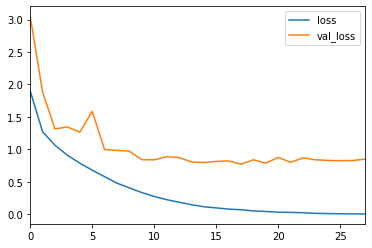

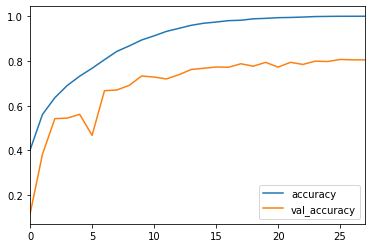

In [35]:
history_df = pd.DataFrame(hist.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

### 5.Prediction on X_test dataset

In [36]:
loss,accuracy = model.evaluate(X_test,Y_test)
print('\ntest loss',loss)
print('accuracy',accuracy)

3600/3600 [==============================] - 8s 2ms/step

test loss 0.8602802191840278
accuracy 0.8016666769981384
